# happiness prediction

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import warnings

# data = np.loadtxt('./bodyfatshuffle.txt')
# data = np.loadtxt('./bodyfat862shuffle.txt')


def KFoldCV(data, ind, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, realY = test[:,:-1], test[:,-1]
        
        predY = model.fit(X_train, y_train).predict(X_test)
        
        results[i,:] = [accuracy_score(realY,predY),precision_score(realY,predY), recall_score(realY,predY), f1_score(realY,predY)]
#         results[i,:] = [accuracy_score(realY,predY),precision_score(realY,predY,average='macro'), recall_score(realY,predY,average='macro'), f1_score(realY,predY,average='macro')]
#         results[i,:] = [accuracy_score(realY,predY),precision_score(realY,predY,average='weighted'), recall_score(realY,predY,average='weighted'), f1_score(realY,predY,average='weighted')]
#     return np.mean(results,0)
    return results

warnings.filterwarnings('ignore')

# data = pd.read_csv('./SomervilleHappinessSurvey2015.csv',sep=',')
data = pd.read_csv('./isHappy.txt')
# data = pd.read_csv('./isHappyFF.txt')
# data = pd.read_csv('./habermanFF.txt')
data = data.values
# data = shuffle(data)

In [2]:
data.shape

(143, 7)

In [39]:
from sklearn.model_selection import GridSearchCV

window_size = 3 # width of the sliding window
step_size = 1 # stride

def sliding_window(X, window_size = 3, step_size = 1): # get each input data (subdataset) using the sliding window
    for i in range(0, X.shape[1] - window_size + 1, step_size):
        yield X[:, i:i+window_size]

def deepCatBoost(train, test,estimator=300, depth=3, window_size = 3, step_size = 1):
    n_features = train.shape[1] - 1
    n_layers = 0
    DCB_MODEL = {}
    DCB_DATA = {}
#     multi-layer construction
#     print('Construction')
    tmp_train = []
    tmp_test = []
    while (n_features > window_size):
#         print(n_features,window_size)
        j = 0
        if n_layers == 0:
            x_train = train[:,:-1]
        else:
            x_train = tmp_train
            tmp_train = []
        for window in sliding_window(x_train):
            DCB_MODEL[n_layers, j] = gridSearch4CatBoost(window, train[:,-1],estimator,depth)
            predY = DCB_MODEL[n_layers, j].predict(window)
            predY = predY.reshape(len(predY),1)
            if len(tmp_train) == 0:
                tmp_train = predY
            else:
                tmp_train = np.append(tmp_train, predY, axis=1)
#             print(tmp_train.shape)
            j = j + 1
        tmp_train = np.array(tmp_train)
        n_features = tmp_train.shape[1]
        n_layers = n_layers + 1
        model = RandomForestClassifier().fit(tmp_train[:,:-1], tmp_train[:,-1])
        importances = model.feature_importances_
        ind = np.argsort(importances)            
        tmp_train[:,:-1] = tmp_train[:,ind]
    final_layer = gridSearch4CatBoost(tmp_train, train[:,-1],estimator,depth)
#         if tmp_train.shape[1] <= window_size:
#             break
#     multi-layer prediction
#     print('prediction')
    for i in range(n_layers):
        j = 0
#         print('layer: ', i+1)
        if i == 0:
            x_test = test[:,:-1]
        else:
            x_test = tmp_test
            tmp_test = []
        for window in sliding_window(x_test):
            predY = DCB_MODEL[i, j].predict(window)
            predY = predY.reshape(len(predY),1)
            if len(tmp_test) == 0:
                tmp_test = predY
            else:
                tmp_test = np.append(tmp_test, predY, axis=1)
            j = j + 1
    final_prediction = final_layer.predict(tmp_test)
    return final_prediction

def gridSearch4CatBoost(X,y,estimator=300, depth=3):
    cbc = CatBoostClassifier(verbose=False,task_type="GPU",devices='0:1')
#     cbc = RandomForestRegressor()
    grid = {'max_depth': [3,4,5],'n_estimators':[10,20,30,40,50,60,70,80,90]}
    gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
    gscv.fit(X,y)
    return gscv.best_estimator_
#     cbc = CatBoostClassifier(n_estimators=estimator, max_depth=depth,verbose=False,task_type="GPU",devices='0:1').fit(X,y)
#     return cbc
#     return model.fit(X,y).predict(testX)

def KFoldDeepCatBoost(data,estimator=300, depth=3, n_fold = 10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, realY = test[:,:-1], test[:,-1]
#         predictY = model.fit(X_train, y_train).predict(X_test)
        predY = deepCatBoost(train, test,estimator, depth)
        results[i,:] = [accuracy_score(realY,predY),precision_score(realY,predY), recall_score(realY,predY), f1_score(realY,predY)]
    return results

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AffinityPropagation

def ensembleCatBoost(train, test,n_estimators, max_depth,labels, importances, ind,n_clusters):
#     models = {}
    trainY = np.zeros((len(train),n_clusters))
    testY = np.zeros((len(test),n_clusters))
#     predY = {}
    finalY = np.zeros((len(test),))
    for i in range(n_clusters):
        class_members = labels == i
        model = gridSearch4CatBoost(train[:,ind[class_members]], train[:,-1],n_estimators, max_depth)
#         models[i] = model
        trainY[:,i] = model.predict(train[:,ind[class_members]])
        testY[:,i] = model.predict(test[:,ind[class_members]])
#         predY = model.predict(test[:,ind[class_members]])
#         finalY = finalY + predY
#     finalY = finalY / n_clusters # simple average, can use soft average
    finalY = gridSearch4CatBoost(trainY, train[:,-1],n_estimators, max_depth).predict(testY)
            
    return finalY

def gridSearch4CatBoost(X,y,n_estimators, max_depth):
    cbc = CatBoostClassifier(verbose=False,task_type="GPU",devices='0:1')
#     cbc = RandomForestRegressor()
    grid = {'max_depth': [3,4,5],'n_estimators':[10,20,30,40,50,60,70,80,90]}
    gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
    gscv.fit(X,y)
    return gscv.best_estimator_
#     cbc = CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth,verbose=False,task_type="GPU",devices='0:1').fit(X,y)
#     return cbc
#     return model.fit(X,y).predict(testX)

def KFold(data, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    labels, importances, ind,n_clusters = getClusterings(data)
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
#         predictY = model.fit(X_train, y_train).predict(X_test)
        predictY = ensembleCatBoost(train, test,n_estimators, max_depth,labels, importances, ind,n_clusters)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(((y-predictY)))
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

def getClusterings(data):
    model = RandomForestClassifier(n_estimators=100, max_depth=3).fit(data[:,:-1], data[:,-1])
    importances = model.feature_importances_
    ind = np.argsort(importances)
#     importances = importances[ind]
    clustering = AffinityPropagation().fit(importances[ind].reshape(-1, 1))
    n_clusters = len(clustering.cluster_centers_indices_)
    return clustering.labels_,importances,ind,n_clusters

In [9]:
from time import time
t1 = time()
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [5]
epochs=1
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFold(data)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))
print(time()-t1)


KeyboardInterrupt



In [29]:
cats

array([[0.64285714, 0.66313492, 0.67366522, 0.66000548],
       [0.66428571, 0.70558442, 0.66689033, 0.66587635],
       [0.66428571, 0.69738095, 0.66898268, 0.66247899],
       [0.61428571, 0.63685065, 0.71535714, 0.65821502],
       [0.65      , 0.67337302, 0.68083333, 0.66836525],
       [0.62142857, 0.67503663, 0.69485931, 0.64740044],
       [0.65      , 0.68833333, 0.66686508, 0.6569888 ],
       [0.57142857, 0.59555556, 0.6781746 , 0.61655443],
       [0.57142857, 0.62361111, 0.5837518 , 0.5707915 ],
       [0.65714286, 0.65490981, 0.69444444, 0.66457768],
       [0.62857143, 0.66265152, 0.64880952, 0.64097618],
       [0.65      , 0.6797619 , 0.67738095, 0.66960163],
       [0.62142857, 0.69275974, 0.61666667, 0.64036701],
       [0.65      , 0.68412698, 0.65674242, 0.65634791],
       [0.64285714, 0.67394661, 0.68646104, 0.65176072],
       [0.65714286, 0.68944444, 0.65400794, 0.65253391],
       [0.66428571, 0.72384921, 0.71126984, 0.69226891],
       [0.60714286, 0.65170635,

In [ ]:
from sklearn.model_selection import GridSearchCV

window_size = 3 # width of the sliding window
step_size = 1 # stride

def sliding_window(X, window_size = 4, step_size = 1): # get each input data (subdataset) using the sliding window
    for i in range(0, X.shape[1] - window_size + 1, step_size):
        yield X[:, i:i+window_size]

def deepCatBoost(train, test,estimator=300, depth=3, window_size = 4, step_size = 1):
    n_features = train.shape[1] - 1
    n_layers = 0
    DCB_MODEL = {}
    DCB_DATA = {}
#     multi-layer construction
#     print('Construction')
    tmp_train = []
    tmp_test = []
    while (n_features > window_size):
#         print(n_features,window_size)
        j = 0
        if n_layers == 0:
            x_train = train[:,:-1]
        else:
            x_train = tmp_train
            tmp_train = []
        for window in sliding_window(x_train):
            DCB_MODEL[n_layers, j] = gridSearch4CatBoost(window, train[:,-1],estimator,depth)
            predY = DCB_MODEL[n_layers, j].predict(window)
            predY = predY.reshape(len(predY),1)
            if len(tmp_train) == 0:
                tmp_train = predY
            else:
                tmp_train = np.append(tmp_train, predY, axis=1)
#             print(tmp_train.shape)
            j = j + 1
        n_features = np.array(tmp_train).shape[1]
        n_layers = n_layers + 1
    final_layer = gridSearch4CatBoost(tmp_train, train[:,-1],estimator,depth)
#         if tmp_train.shape[1] <= window_size:
#             break
#     multi-layer prediction
#     print('prediction')
    for i in range(n_layers):
        j = 0
#         print('layer: ', i+1)
        if i == 0:
            x_test = test[:,:-1]
        else:
            x_test = tmp_test
            tmp_test = []
        for window in sliding_window(x_test):
            predY = DCB_MODEL[i, j].predict(window)
            predY = predY.reshape(len(predY),1)
            if len(tmp_test) == 0:
                tmp_test = predY
            else:
                tmp_test = np.append(tmp_test, predY, axis=1)
            j = j + 1
    final_prediction = final_layer.predict(tmp_test)
    return final_prediction

def gridSearch4CatBoost(X,y,estimator=300, depth=3):
#     cbc = CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1')
# #     cbc = RandomForestRegressor()
#     grid = {'max_depth': [3,4,5],'n_estimators':[100,300,500]}
#     gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
#     gscv.fit(X,y)
#     return gscv.best_estimator_
    cbc = CatBoostClassifier(n_estimators=estimator, max_depth=depth,verbose=False,task_type="GPU",devices='0:1').fit(X,y)
    return cbc
#     return model.fit(X,y).predict(testX)

def KFoldDeepCatBoost(data,estimator=300, depth=3, n_fold = 10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, realY = test[:,:-1], test[:,-1]
#         predictY = model.fit(X_train, y_train).predict(X_test)
        predY = deepCatBoost(train, test,estimator, depth)
        results[i,:] = [accuracy_score(realY,predY),precision_score(realY,predY), recall_score(realY,predY), f1_score(realY,predY)]
    return results

In [ ]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [10]
max_depth = [4]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestClassifier().fit(data[:,:-1], data[:,-1])
            importances = model.feature_importances_
            ind = np.argsort(importances)            
            data[:,:-1] = data[:,ind]
            result = KFoldDeepCatBoost(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

In [2]:
cats = np.array([[0.65      , 0.75019841, 0.6903824 , 0.67664063],
       [0.66428571, 0.69095238, 0.68630952, 0.67942308],
       [0.67142857, 0.67207792, 0.74543651, 0.69758942],
       [0.64285714, 0.67927489, 0.71753968, 0.67835044],
       [0.63571429, 0.67924603, 0.65399711, 0.63917679],
       [0.62857143, 0.61799451, 0.67662338, 0.62825224],
       [0.65714286, 0.67468254, 0.72099206, 0.67535319],
       [0.65714286, 0.66541126, 0.73896825, 0.68511456],
       [0.65714286, 0.6865873 , 0.71035714, 0.68660756],
       [0.67142857, 0.71      , 0.71464286, 0.69843642],
       [0.67142857, 0.67207792, 0.74543651, 0.69758942],
       [0.73571429, 0.74371212, 0.77059524, 0.74858392],
       [0.69285714, 0.70217172, 0.70988095, 0.69726496],
       [0.62857143, 0.6615873 , 0.65654762, 0.65206134],
       [0.67142857, 0.67063492, 0.78075397, 0.7079259 ],
       [0.73571429, 0.74371212, 0.77059524, 0.74858392],
       [0.69285714, 0.70217172, 0.70988095, 0.69726496],
       [0.63571429, 0.66904762, 0.6717316 , 0.65088288],
       [0.65714286, 0.66541126, 0.73896825, 0.68511456],
       [0.67142857, 0.71      , 0.71464286, 0.69843642]])
print(np.mean(cats, axis=0))

[0.66642857 0.6883476  0.7162141  0.68643263]


In [2]:
mlp = np.array([[0.53571429, 0.62113997, 0.6375    , 0.55890766],
       [0.54285714, 0.56705794, 0.79781746, 0.62978755],
       [0.52142857, 0.53162365, 0.67555556, 0.57886128],
       [0.52142857, 0.59057359, 0.58218254, 0.53607561],
       [0.51428571, 0.54285437, 0.74809524, 0.60356553],
       [0.57857143, 0.63276335, 0.64809524, 0.60403991],
       [0.57142857, 0.5981746 , 0.6931746 , 0.62289593],
       [0.50714286, 0.55770924, 0.6456746 , 0.55794626],
       [0.55      , 0.55222222, 0.51665224, 0.51143979],
       [0.59285714, 0.59363858, 0.77079365, 0.65308543],
       [0.53571429, 0.55090354, 0.64011905, 0.56867695],
       [0.59285714, 0.63555556, 0.69069625, 0.63828591],
       [0.57857143, 0.58990565, 0.7588456 , 0.64287879],
       [0.55      , 0.58330891, 0.77045455, 0.62527464],
       [0.5       , 0.54716755, 0.63722222, 0.56974568],
       [0.5       , 0.54849206, 0.67492063, 0.56204545],
       [0.63571429, 0.62615884, 0.77535714, 0.67145897],
       [0.55714286, 0.56706072, 0.75924242, 0.63171132],
       [0.55      , 0.57638889, 0.66833333, 0.60739496],
       [0.54285714, 0.53590188, 0.70055556, 0.5965437 ]])
svm = np.array([[0.60714286, 0.60993867, 0.77748918, 0.66933024],
       [0.58571429, 0.60048701, 0.71265873, 0.62774637],
       [0.59285714, 0.59638889, 0.71634921, 0.63777149],
       [0.65714286, 0.65974026, 0.78776696, 0.70151334],
       [0.59285714, 0.59386003, 0.74865079, 0.65337719],
       [0.62142857, 0.60713509, 0.81279138, 0.66994553],
       [0.61428571, 0.62391414, 0.71617965, 0.65356157],
       [0.55714286, 0.5762518 , 0.70876984, 0.62334233],
       [0.55      , 0.57121989, 0.68309524, 0.59430529],
       [0.55      , 0.55502165, 0.68769841, 0.60789467],
       [0.59285714, 0.6237013 , 0.7615873 , 0.66334881],
       [0.57142857, 0.58010101, 0.68444444, 0.61753647],
       [0.6       , 0.62949134, 0.72391414, 0.64612512],
       [0.57857143, 0.58623737, 0.70737374, 0.62309167],
       [0.60714286, 0.6274284 , 0.76285714, 0.6719883 ],
       [0.62857143, 0.62308081, 0.7463456 , 0.6644615 ],
       [0.60714286, 0.59953768, 0.77103175, 0.66312294],
       [0.54285714, 0.53111111, 0.68333333, 0.57352227],
       [0.63571429, 0.64108947, 0.73396825, 0.67802772],
       [0.62142857, 0.63467532, 0.75797619, 0.67138552]])
rf = np.array([[0.61428571, 0.63099206, 0.71025974, 0.64575002],
       [0.58571429, 0.60079365, 0.63863997, 0.60013457],
       [0.62142857, 0.65689949, 0.69042208, 0.65571139],
       [0.59285714, 0.65694722, 0.70666667, 0.63002055],
       [0.61428571, 0.6325    , 0.70359307, 0.64318598],
       [0.57857143, 0.59684343, 0.63880952, 0.59911593],
       [0.58571429, 0.63710317, 0.66668831, 0.63322343],
       [0.56428571, 0.59046537, 0.65772006, 0.60699849],
       [0.59285714, 0.61764791, 0.68555556, 0.63196581],
       [0.60714286, 0.6444697 , 0.69305556, 0.62611811],
       [0.62857143, 0.64150794, 0.74063492, 0.67406777],
       [0.61428571, 0.6327381 , 0.6902381 , 0.65387452],
       [0.60714286, 0.64613276, 0.7034127 , 0.65129336],
       [0.6       , 0.6269228 , 0.66769841, 0.62961181],
       [0.56428571, 0.59968254, 0.62966089, 0.58890271],
       [0.6       , 0.63551587, 0.67166667, 0.63727591],
       [0.62857143, 0.65414502, 0.68611111, 0.65032262],
       [0.61428571, 0.65777778, 0.68180375, 0.6429972 ],
       [0.60714286, 0.64031746, 0.65353175, 0.62892408],
       [0.6       , 0.63606061, 0.68797453, 0.63165495]])
xgb = np.array([[0.59285714, 0.62707071, 0.65202381, 0.62356982],
       [0.61428571, 0.63401515, 0.74615079, 0.65812557],
       [0.54285714, 0.56150794, 0.605     , 0.56958987],
       [0.57142857, 0.60883838, 0.6627381 , 0.62051821],
       [0.58571429, 0.6233153 , 0.69416667, 0.62939076],
       [0.59285714, 0.64079365, 0.67361111, 0.62990737],
       [0.6       , 0.62010101, 0.71526696, 0.64373071],
       [0.56428571, 0.60358225, 0.62130952, 0.59254011],
       [0.60714286, 0.62178571, 0.7027381 , 0.64438991],
       [0.56428571, 0.57444444, 0.61      , 0.57541083],
       [0.60714286, 0.60257937, 0.62614719, 0.60421484],
       [0.59285714, 0.62313492, 0.68571429, 0.63428356],
       [0.60714286, 0.63355339, 0.68404762, 0.6411236 ],
       [0.59285714, 0.63046537, 0.64281746, 0.62071429],
       [0.56428571, 0.60662698, 0.6452381 , 0.60114058],
       [0.57142857, 0.59722222, 0.62566017, 0.60377291],
       [0.57142857, 0.59738817, 0.64618326, 0.60051453],
       [0.57857143, 0.61121573, 0.67626984, 0.6085488 ],
       [0.58571429, 0.63045455, 0.6672619 , 0.63172373],
       [0.56428571, 0.60075092, 0.62974026, 0.59705954]])
cat = np.array([[0.60714286, 0.63857143, 0.6515368 , 0.63628233],
       [0.63571429, 0.67208153, 0.74666667, 0.6751965 ],
       [0.55      , 0.60352814, 0.675     , 0.59972798],
       [0.56428571, 0.58471861, 0.61376984, 0.58740627],
       [0.55714286, 0.59404762, 0.635     , 0.60016609],
       [0.59285714, 0.59737013, 0.70111111, 0.62867916],
       [0.6       , 0.6228083 , 0.67900794, 0.63657747],
       [0.61428571, 0.65849206, 0.66357143, 0.64188694],
       [0.55714286, 0.63733766, 0.65011905, 0.59486713],
       [0.62142857, 0.65172078, 0.67527778, 0.64989873],
       [0.58571429, 0.62210317, 0.67275253, 0.6217085 ],
       [0.55      , 0.58835498, 0.67608225, 0.58381437],
       [0.55714286, 0.61142857, 0.61369048, 0.5911262 ],
       [0.61428571, 0.63583333, 0.66607143, 0.64161125],
       [0.59285714, 0.62452381, 0.64781746, 0.60577717],
       [0.58571429, 0.61730159, 0.62912698, 0.60503776],
       [0.59285714, 0.598557  , 0.64698413, 0.60952528],
       [0.57857143, 0.62043651, 0.64472222, 0.61353175],
       [0.62142857, 0.66047619, 0.65781746, 0.64772142],
       [0.57142857, 0.62314574, 0.6178355 , 0.60437761]])
hm=np.array([[0.60714286, 0.64613276, 0.69420635, 0.65159701],
       [0.61428571, 0.65565657, 0.71087302, 0.66148281],
       [0.62857143, 0.64037879, 0.74003968, 0.67806581],
       [0.62142857, 0.64756799, 0.74103175, 0.6736675 ],
       [0.60714286, 0.64264735, 0.7059127 , 0.65066563],
       [0.63571429, 0.65482323, 0.72130952, 0.67343137],
       [0.63571429, 0.65482323, 0.72130952, 0.67343137],
       [0.59285714, 0.62393162, 0.7090873 , 0.64331933],
       [0.62857143, 0.66088023, 0.72198413, 0.67177245],
       [0.59285714, 0.62454545, 0.68468254, 0.64008907],
       [0.63571429, 0.66262626, 0.73420635, 0.68259588],
       [0.6       , 0.63559829, 0.70325397, 0.65064119],
       [0.61428571, 0.6409596 , 0.71325397, 0.66032987],
       [0.63571429, 0.65482323, 0.72130952, 0.67343137],
       [0.6       , 0.63176768, 0.70452381, 0.65015443],
       [0.60714286, 0.64343434, 0.6990873 , 0.65120374],
       [0.61428571, 0.65565657, 0.71087302, 0.66148281],
       [0.60714286, 0.64343434, 0.6990873 , 0.65120374],
       [0.59285714, 0.64059829, 0.6965873 , 0.64251401],
       [0.61428571, 0.64113276, 0.71642857, 0.66504239]])
# SWD-CatBoost
cats = np.array([[0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.65714286, 0.70333333, 0.66768398, 0.66581197],
       [0.67142857, 0.7243254 , 0.69177489, 0.6873575 ],
       [0.69285714, 0.71372294, 0.72579004, 0.70536235],
       [0.71428571, 0.74138889, 0.77141775, 0.73728745],
       [0.67857143, 0.74027778, 0.66351732, 0.68259393],
       [0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.65714286, 0.69984127, 0.69268398, 0.67827534],
       [0.67142857, 0.68830087, 0.72995671, 0.6940017 ],
       [0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.67857143, 0.74027778, 0.66351732, 0.68259393],
       [0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.67142857, 0.7243254 , 0.69177489, 0.6873575 ],
       [0.66428571, 0.70079365, 0.66503247, 0.66814215],
       [0.67142857, 0.7243254 , 0.69177489, 0.6873575 ],
       [0.68571429, 0.72538961, 0.69169913, 0.69015873],
       [0.67142857, 0.7243254 , 0.69177489, 0.6873575 ],
       [0.64285714, 0.69083333, 0.67601732, 0.66281046],
       [0.67857143, 0.74027778, 0.66351732, 0.68259393]])

In [16]:
from scipy.stats import ranksums

for i in range(4):
    print(ranksums(mlp[:,i], cats[:,i]).pvalue)
    print(ranksums(svm[:,i], cats[:,i]).pvalue)
    print(ranksums(rf[:,i], cats[:,i]).pvalue)
    print(ranksums(xgb[:,i], cats[:,i]).pvalue)
    print(ranksums(cat[:,i], cats[:,i]).pvalue)
    print(ranksums(hm[:,i], cats[:,i]).pvalue)
    print()

6.301848221392269e-08
1.7827968013624886e-07
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

0.892413863968481
0.0001699389127330722
0.6651590382763763
0.017293486431260986
0.0011703444685277223
0.0001524694538213556

2.062471174491123e-07
0.0007959163393098394
2.062471174491123e-07
6.301848221392269e-08
2.062471174491123e-07
0.00028928371617217385



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

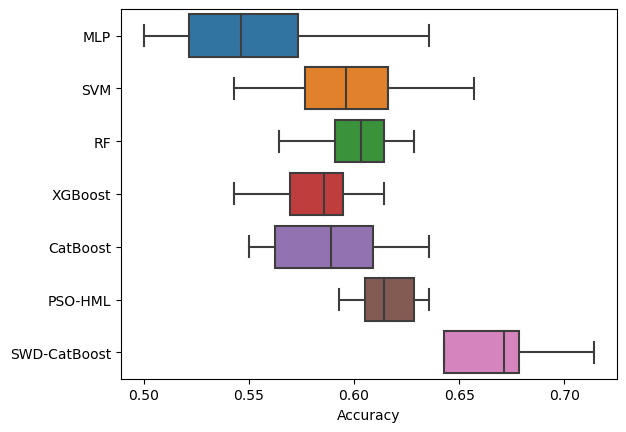

In [18]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost'])
i = 0
df["MLP"] = mlp[:, i]
df["SVM"] = svm[:, i]
df["RF"] = rf[:, i]
df["XGBoost"] = xgb[:, i]
df["CatBoost"] = cat[:, i]
df["PSO-HML"] = hm[:, i]
df["SWD-CatBoost"] = cats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="Accuracy")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('swdAcc.eps', format='eps',bbox_inches  ='tight')

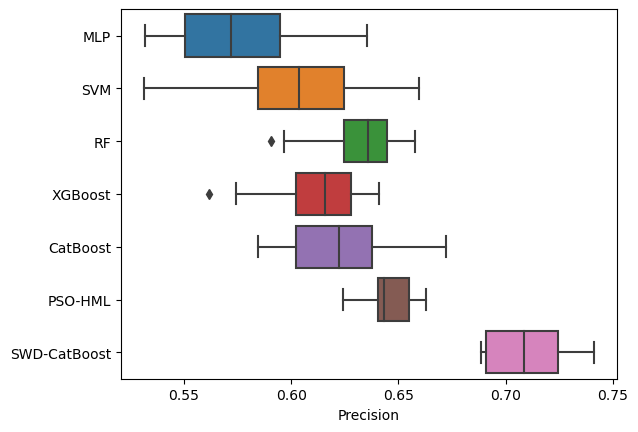

In [19]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost'])
i = 1
df["MLP"] = mlp[:, i]
df["SVM"] = svm[:, i]
df["RF"] = rf[:, i]
df["XGBoost"] = xgb[:, i]
df["CatBoost"] = cat[:, i]
df["PSO-HML"] = hm[:, i]
df["SWD-CatBoost"] = cats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="Precision")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('swdPre.eps', format='eps',bbox_inches  ='tight')

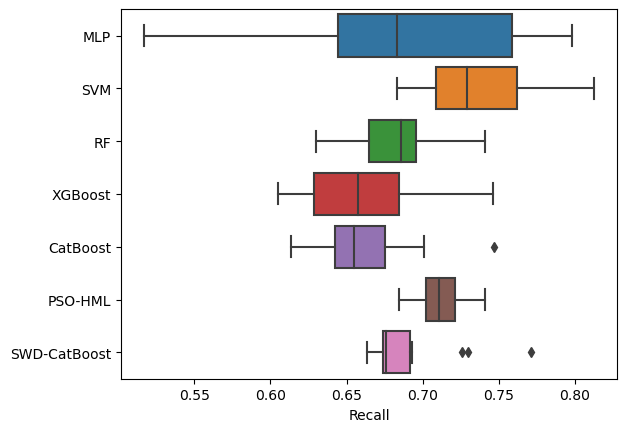

In [20]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost'])
i = 2
df["MLP"] = mlp[:, i]
df["SVM"] = svm[:, i]
df["RF"] = rf[:, i]
df["XGBoost"] = xgb[:, i]
df["CatBoost"] = cat[:, i]
df["PSO-HML"] = hm[:, i]
df["SWD-CatBoost"] = cats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="Recall")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('swdRec.eps', format='eps',bbox_inches  ='tight')

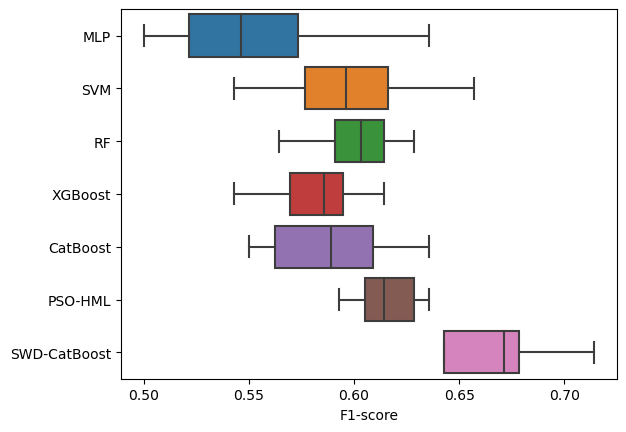

In [21]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost'])
i = 0
df["MLP"] = mlp[:, i]
df["SVM"] = svm[:, i]
df["RF"] = rf[:, i]
df["XGBoost"] = xgb[:, i]
df["CatBoost"] = cat[:, i]
df["PSO-HML"] = hm[:, i]
df["SWD-CatBoost"] = cats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="F1-score")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('swdF1.eps', format='eps',bbox_inches  ='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


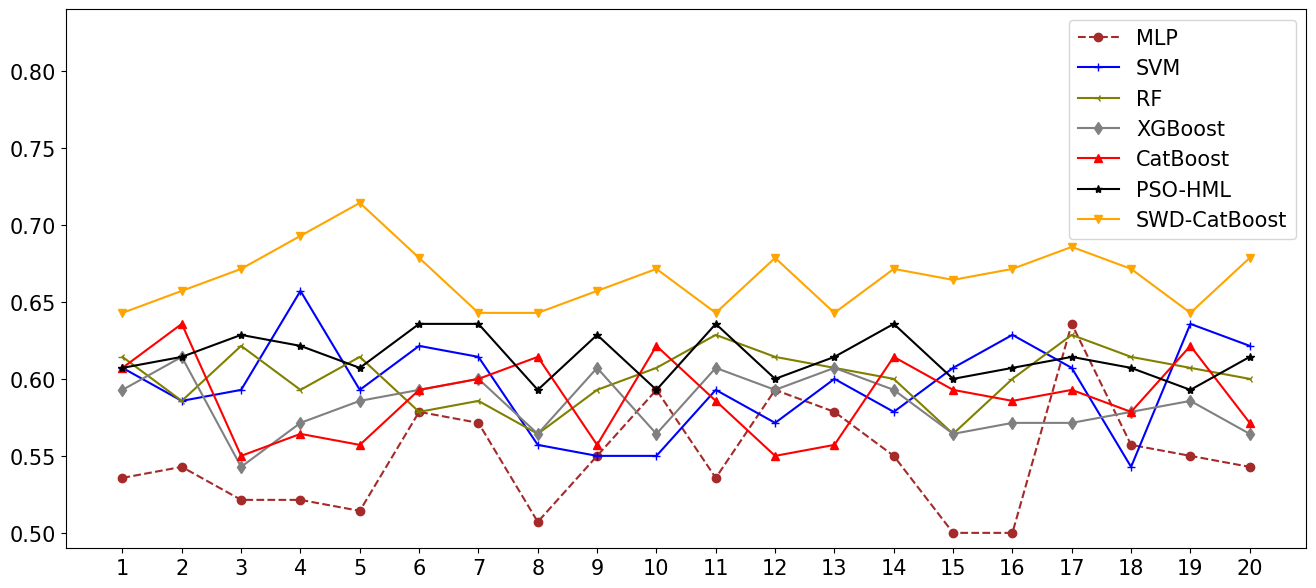

In [12]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


names = ['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost']

figure(num=None, figsize=(16, 7))
plt.plot(range(1,21),mlp[:,0], color = 'brown',linestyle='dashed',marker='o', label='MLP')
plt.plot(range(1,21),svm[:,0],color = 'blue',marker='+',label = 'SVM')
plt.plot(range(1,21),rf[:,0], color = 'olive' ,marker='3', label='RF')
plt.plot(range(1,21),xgb[:,0], color = 'gray',marker='d', label='XGBoost')
plt.plot(range(1,21),cat[:,0], color = 'red' ,marker='^', label='CatBoost')
plt.plot(range(1,21),hm[:,0], color = 'black' ,marker='*', label='PSO-HML')
plt.plot(range(1,21),cats[:,0], color = 'orange' ,marker='v', label='SWD-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 15}
plt.rcParams.update({'font.size': 17})
plt.rc('font', **font)
plt.ylim(0.49, 0.84)
plt.xticks(range(1,21),['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
plt.legend()
plt.savefig('20runsAcc.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


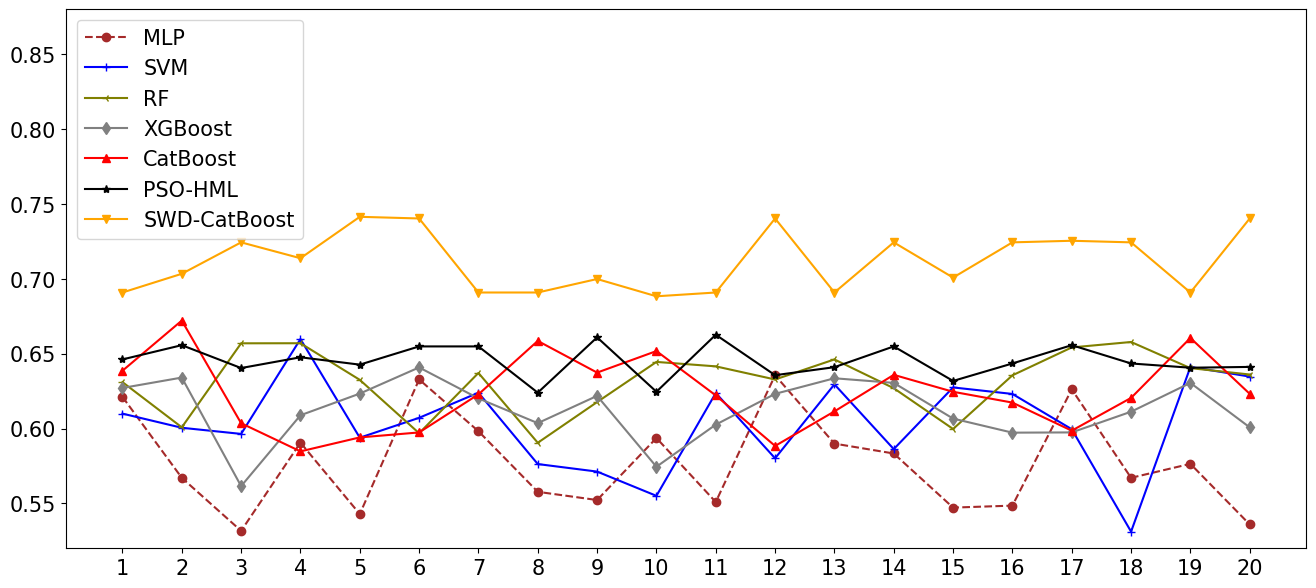

In [17]:
from matplotlib.pyplot import figure


names = ['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost']

figure(num=None, figsize=(16, 7))
plt.plot(range(1,21),mlp[:,1], color = 'brown',linestyle='dashed',marker='o', label='MLP')
plt.plot(range(1,21),svm[:,1],color = 'blue',marker='+',label = 'SVM')
plt.plot(range(1,21),rf[:,1], color = 'olive' ,marker='3', label='RF')
plt.plot(range(1,21),xgb[:,1], color = 'gray',marker='d', label='XGBoost')
plt.plot(range(1,21),cat[:,1], color = 'red' ,marker='^', label='CatBoost')
plt.plot(range(1,21),hm[:,1], color = 'black' ,marker='*', label='PSO-HML')
plt.plot(range(1,21),cats[:,1], color = 'orange' ,marker='v', label='SWD-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 15}
plt.rcParams.update({'font.size': 17})
plt.rc('font', **font)
plt.ylim(0.52, 0.88)
plt.xticks(range(1,21),['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
plt.legend()
plt.savefig('20runsPre.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


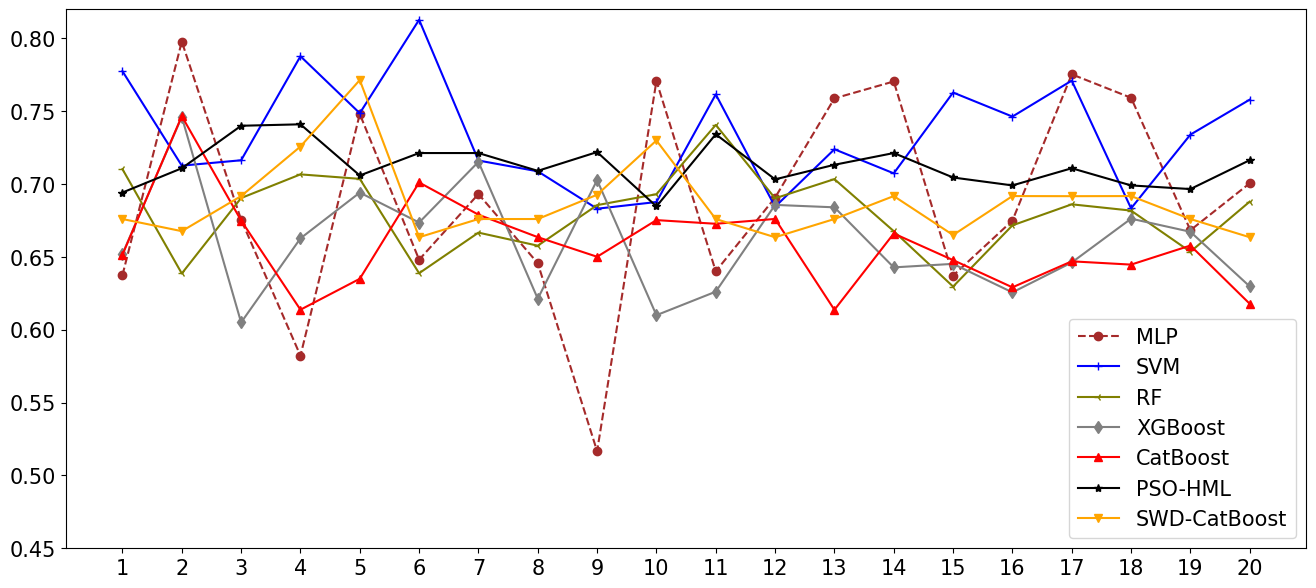

In [19]:
###### from matplotlib.pyplot import figure


names = ['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost']

figure(num=None, figsize=(16, 7))
plt.plot(range(1,21),mlp[:,2], color = 'brown',linestyle='dashed',marker='o', label='MLP')
plt.plot(range(1,21),svm[:,2],color = 'blue',marker='+',label = 'SVM')
plt.plot(range(1,21),rf[:,2], color = 'olive' ,marker='3', label='RF')
plt.plot(range(1,21),xgb[:,2], color = 'gray',marker='d', label='XGBoost')
plt.plot(range(1,21),cat[:,2], color = 'red' ,marker='^', label='CatBoost')
plt.plot(range(1,21),hm[:,2], color = 'black' ,marker='*', label='PSO-HML')
plt.plot(range(1,21),cats[:,2], color = 'orange' ,marker='v', label='SWD-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 15}
plt.rcParams.update({'font.size': 17})
plt.rc('font', **font)
plt.ylim(0.45, 0.82)
plt.xticks(range(1,21),['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
plt.legend()
plt.savefig('20runsRec.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


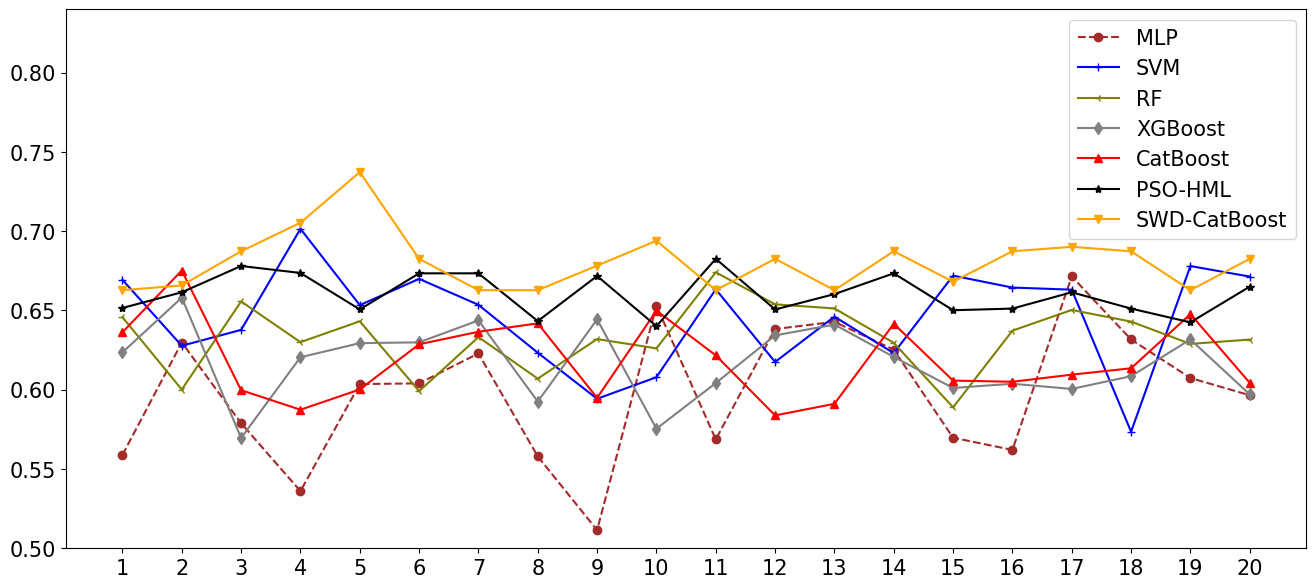

In [20]:
from matplotlib.pyplot import figure


names = ['MLP', 'SVM',"RF","XGBoost","CatBoost", 'PSO-HML', 'SWD-CatBoost']

figure(num=None, figsize=(16, 7))
plt.plot(range(1,21),mlp[:,-1], color = 'brown',linestyle='dashed',marker='o', label='MLP')
plt.plot(range(1,21),svm[:,-1],color = 'blue',marker='+',label = 'SVM')
plt.plot(range(1,21),rf[:,-1], color = 'olive' ,marker='3', label='RF')
plt.plot(range(1,21),xgb[:,-1], color = 'gray',marker='d', label='XGBoost')
plt.plot(range(1,21),cat[:,-1], color = 'red' ,marker='^', label='CatBoost')
plt.plot(range(1,21),hm[:,-1], color = 'black' ,marker='*', label='PSO-HML')
plt.plot(range(1,21),cats[:,-1], color = 'orange' ,marker='v', label='SWD-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 15}
plt.rcParams.update({'font.size': 17})
plt.rc('font', **font)
plt.ylim(0.5, 0.84)
plt.xticks(range(1,21),['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
plt.legend()
plt.savefig('20runsF1.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()